In [1]:
import torch
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

torch.__version__

'1.0.1.post2'

In [2]:
# Load data to dataloader
from torchvision import datasets
import torchvision.transforms as transforms

batch = 64

transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch)

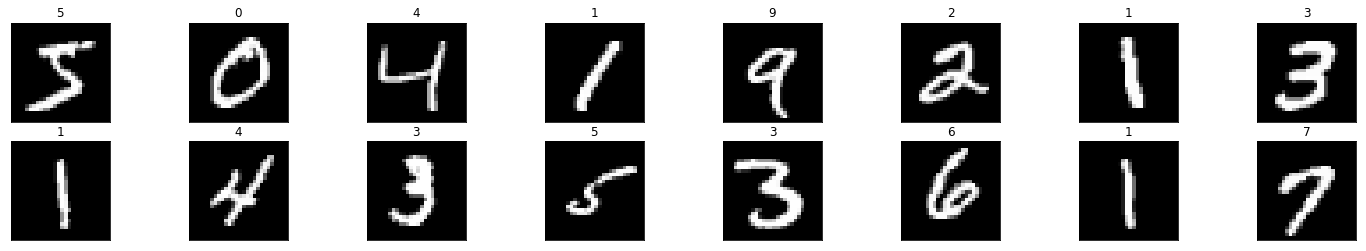

In [3]:
# Input visualization
import matplotlib.pyplot as plt
%matplotlib inline

dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(str(labels[idx].item()))


In [4]:
# Define the network architecture
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):    
    def __init__(self):
        super(Net, self).__init__()
          
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(p = 0.25),
            nn.Conv2d(32, 64, kernel_size=3, stride=1,padding=1),
             nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
             nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1,padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         
            nn.Dropout(p = 0.25),
        )
          
        self.classifier = nn.Sequential(
            nn.Dropout(p = 0.25),
            nn.Linear(128 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.25),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) 
        x = self.classifier(x)
        return x

model = Net()
print(model)

Net(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.25)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [5]:
# Define loss and optimizer
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [6]:
# Training for 100 epochs
def train(epoch):
    model.train()
    exp_lr_scheduler.step()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        
        if torch.cuda.is_available():
            data = data.cuda()
            target = target.cuda()
        
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        
        loss.backward()
        optimizer.step()
        
        if (batch_idx + 1)% 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),100. * (batch_idx + 1) / len(train_loader), loss.item()))

In [7]:
# Testing
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            if torch.cuda.is_available():
                data = data.cuda()
                target = target.cuda()

            output = model(data)

            loss += F.cross_entropy(output, target, size_average=False).item()

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(loss, correct, len(data_loader.dataset),100. * correct / len(data_loader.dataset)))

In [8]:
n_epochs = 3

for epoch in range(n_epochs):
    train(epoch)

Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.112144
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.258391
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.176558
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.269816
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.262021
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.124301
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.093391
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.087775
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.085686
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.108311
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.045334
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.088211
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.167108
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.019855
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.031699
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.025063
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.028303
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.083768
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.110990
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.172845
Tra

In [9]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    for i, data in enumerate(data_loader):
        data = Variable(data, volatile=True)
        if torch.cuda.is_available():
            data = data.cuda()
            
        output = model(data)
        
        pred = output.cpu().data.max(1, keepdim=True)[1]
        test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred
test_pred = prediciton(test_loader)
print('\nOverall Prediction -> {}'.format(test_pred))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  


TypeError: Variable data has to be a tensor, but got list